# Multilayer Perceptrons and Convolutional Neural Networks
In this notebook, I will investigate different deep learning networks to get insights about MLPs and CNNs.
## Loading Dataset
For this exploration, the Fashion MNIST dataset will be used. First, I download the data and use a dataloader to create train and test sets with 32 size minibatches. A transform is used to preprocess the data to make the images have a mean and stdiv of 0.5.

In [7]:
import torch
import numpy as np
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [9]:
from torchvision import datasets , transforms
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5, ) ,(0.5, ))])

trainset = datasets.FashionMNIST(' ~/. pytorch / F_MNIST_data / ' , download = True , train = True , transform = transform)

trainloader = torch.utils.data.DataLoader( trainset , batch_size=32 , shuffle = True )

testset = datasets.FashionMNIST(' ~/. pytorch / F_MNIST_data / ', download = True , train = False , transform = transform )

testloader = torch.utils.data.DataLoader( testset , batch_size =32 , shuffle = False )

In [10]:
batch = next ( iter ( trainloader ) )
print ( batch [0]. shape , batch [1]. shape )

torch.Size([32, 1, 28, 28]) torch.Size([32])


The Fashion MNIST dataset consists of 28 by 28 pixel images. Each corresponding to some labeled fashion item. This task is a multiclass classification task to identify the correct fashion item.

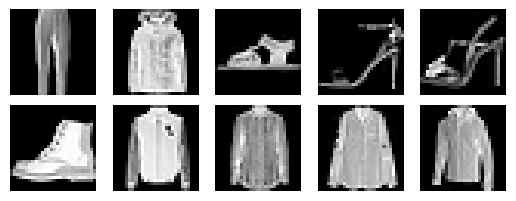

In [11]:
import matplotlib . pyplot as plt
f , ax = plt . subplots (2 , 5)
plt . subplots_adjust ( bottom =0.3 , top =0.7 , hspace =0)
for i in range (2) :
    for j in range (5) :
        image , label = next ( iter ( trainloader ) )
        ax [ i ][ j ]. set_axis_off ()
        ax [ i ][ j ]. imshow ( image [0 ,0 ,:] , cmap = 'gray')

The images are labeled by their class from 0-9. There are 10 possible classes and each image corresponds to only one class.

In [12]:
image, label = next(iter(trainloader))
print(label)

tensor([3, 4, 7, 9, 7, 7, 8, 9, 2, 6, 0, 4, 8, 2, 6, 0, 7, 5, 5, 0, 1, 7, 5, 1,
        5, 3, 9, 0, 3, 8, 0, 3])


## Multilayer Perceptron
### Naive Wide MLP
A multilayer perceptron can be used in this classification task if the final output size is the number of possible classes (10). The 28 by 28 two-dimensional imags can be flattened into an array of 784 to input to the MLP.

To start, let's create a multilayer perceptron with a single hidden layer that is very wide. With enough neurons, this MLP should be able to represent the data generating mechanism, because MLPs are universal function approximators.

In [99]:
import torch.nn as nn
class MLP_wide(nn.Module):
    def __init__(self, hidden_size, act_fn = nn.ReLU):
        super().__init__()
        self.linear = nn.Linear(28*28,hidden_size)
        self.relu = act_fn()
        self.linear2 = nn.Linear(hidden_size, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        hidden = self.linear(x)
        output = self.linear2(self.relu(hidden))
        return output

In [14]:
model = MLP_wide(1000)

In [78]:
import torch.optim as optim

def train(model, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    num_epochs = 15
    batch_size = 32
    
    loss_array = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        for X_batch, y_batch in trainloader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss_array[epoch] += loss.detach().numpy()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        print(f"Epoch {epoch} loss: {loss_array[epoch]}")

In [16]:
train(model)

Epoch 0 loss: 1181.3125073164701
Epoch 1 loss: 846.6676965877414
Epoch 2 loss: 771.7745471447706
Epoch 3 loss: 722.9470726177096
Epoch 4 loss: 688.3533755838871
Epoch 5 loss: 659.1135737374425
Epoch 6 loss: 636.3926494941115
Epoch 7 loss: 614.2905514612794
Epoch 8 loss: 595.5465082488954
Epoch 9 loss: 577.5215908437967
Epoch 10 loss: 563.3182978220284
Epoch 11 loss: 546.7695145793259
Epoch 12 loss: 534.4723323024809
Epoch 13 loss: 519.9211301207542
Epoch 14 loss: 508.1568845808506


In [17]:
def evaluate(model):
    model.eval()
    total_correct_test = 0
    total_samples_test = 0
    total_correct_train = 0
    total_samples_train = 0
    with torch.no_grad():
        
        ## --- Test Set Accuracy ---
        for X_batch, y_batch in testloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, axis=1)
            
            # Count correct predictions and total samples in this batch
            correct_count = (predicted == y_batch).sum().item()
            batch_size = y_batch.shape[0]
            
            # Aggregate totals
            total_correct_test += correct_count
            total_samples_test += batch_size
    
        ## --- Training Set Accuracy ---
        for X_batch, y_batch in trainloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, axis=1)
            
            # Count correct predictions and total samples in this batch
            correct_count = (predicted == y_batch).sum().item()
            batch_size = y_batch.shape[0]
            
            # Aggregate totals
            total_correct_train += correct_count
            total_samples_train += batch_size
    
    # Final calculation: total correct / total samples
    final_test_accuracy = total_correct_test / total_samples_test
    final_train_accuracy = total_correct_train / total_samples_train
    
    print(f"Final test accuracy: {final_test_accuracy:.4f}")
    print(f"Final train accuracy: {final_train_accuracy:.4f}")
    return final_train_accuracy, final_test_accuracy

In [18]:
evaluate(model)

Final test accuracy: 0.8775
Final train accuracy: 0.9062


(0.9062, 0.8775)

As seen, for a fairly wide, single hidden layer MLP, the network was able to learn the classification task. This shows that MLPs are universal function approximators. 

### Representative Power Under Limited Neurons
However, this required a lot of neurons to achieve a good accuracy. I will experiment what happens when the number of neurons is reduced. This emulates a scenario where computational performance and memory are considerations, such that we cannot just use an infinite width network.

In [20]:
model = MLP_wide(100)
train(model)

Epoch 0 loss: 1249.8863081783056
Epoch 1 loss: 875.4983744323254
Epoch 2 loss: 802.8562923520803
Epoch 3 loss: 757.7285491377115
Epoch 4 loss: 724.0746468752623
Epoch 5 loss: 697.9762238115072
Epoch 6 loss: 675.1848358437419
Epoch 7 loss: 654.9972181729972
Epoch 8 loss: 638.9084850586951
Epoch 9 loss: 623.7545437254012
Epoch 10 loss: 610.0962006859481
Epoch 11 loss: 596.864517968148
Epoch 12 loss: 585.0824247524142
Epoch 13 loss: 573.5172885153443
Epoch 14 loss: 561.8608360998333


In [21]:
evaluate(model)

Final test accuracy: 0.8715
Final train accuracy: 0.8960


(0.8959666666666667, 0.8715)

As seen, there is some loss of generalizability when the width decreases. I will experiment how this changes as the hidden layer width decreases further.

In [22]:
hidden_sizes = [5,10,20,40,100]

test_accs = []

for h in hidden_sizes:
    model = MLP_wide(h)
    train(model)
    _, test_acc = evaluate(model)
    test_accs.append(test_acc)

Epoch 0 loss: 1826.872157305479
Epoch 1 loss: 1183.2936452627182
Epoch 2 loss: 1095.6646146774292
Epoch 3 loss: 1052.373255893588
Epoch 4 loss: 1010.528885319829
Epoch 5 loss: 977.4917377084494
Epoch 6 loss: 954.7922272309661
Epoch 7 loss: 940.0917900204659
Epoch 8 loss: 928.7879093885422
Epoch 9 loss: 916.9201606214046
Epoch 10 loss: 909.2445978671312
Epoch 11 loss: 900.9014773517847
Epoch 12 loss: 895.8695747852325
Epoch 13 loss: 889.6444671526551
Epoch 14 loss: 884.03700260818
Final test accuracy: 0.8211
Final train accuracy: 0.8373
Epoch 0 loss: 1364.677837267518
Epoch 1 loss: 963.7802959382534
Epoch 2 loss: 892.9972154721618
Epoch 3 loss: 853.9947587177157
Epoch 4 loss: 829.2214992120862
Epoch 5 loss: 809.9988737925887
Epoch 6 loss: 793.7449471354485
Epoch 7 loss: 780.3639495000243
Epoch 8 loss: 768.474149428308
Epoch 9 loss: 758.3441342115402
Epoch 10 loss: 749.8921738788486
Epoch 11 loss: 743.332201756537
Epoch 12 loss: 735.4852378517389
Epoch 13 loss: 728.0476185083389
Epoch 14

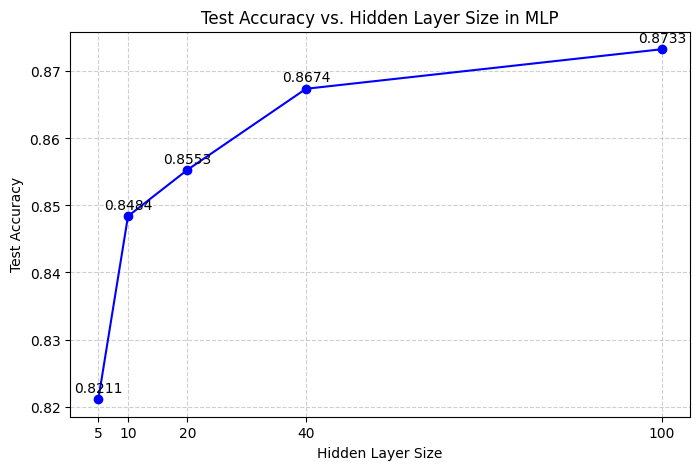

In [23]:
import matplotlib.pyplot as plt

# Code adapted from GeminiAI (Google 2025)
# Prompt: use matplotlib to make a graph of the hiddensizes and test accs ...

plt.figure(figsize=(8, 5))
plt.plot(hidden_sizes, test_accs, marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('Test Accuracy vs. Hidden Layer Size in MLP')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Test Accuracy')

# Customize plot for readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(hidden_sizes)

# Add annotations (optional, but helpful)
for i in range(len(hidden_sizes)):
    plt.annotate(
        f'{test_accs[i]:.4f}', 
        (hidden_sizes[i], test_accs[i]), 
        textcoords="offset points", 
        xytext=(0,5), 
        ha='center'
    )

plt.show()

As seen, there is a dependence on the performance of the model and the size of this hidden layer. This demonstrates that MLPs with a finite number of neurons only have limited representative power.

So when we have this constraint of limited neurons, other architectures can represent more complex relationships with the same number of neurons as the naive, single hidden layer MLP.

### Increasing Depth and Sufficiency of Architecture
Instead of stacking neurons all into one hidden layer, creating depth is a strategy to gain more complex operations. For the remainder of this section, we will limit our network to a maximum of 30 neurons across hidden layers to emulate some constraint on memory and computation.

First, we train a baseline model using the naive single hidden layer architecture.

In [24]:
model = MLP_wide(30)
train(model)

Epoch 0 loss: 1304.4569514989853
Epoch 1 loss: 892.0649543777108
Epoch 2 loss: 820.2406633421779
Epoch 3 loss: 776.2761005610228
Epoch 4 loss: 746.0540105253458
Epoch 5 loss: 723.803630862385
Epoch 6 loss: 705.5356229580939
Epoch 7 loss: 685.3990273997188
Epoch 8 loss: 671.7189192771912
Epoch 9 loss: 658.4971538037062
Epoch 10 loss: 647.4517865180969
Epoch 11 loss: 635.3721902295947
Epoch 12 loss: 625.7889706380665
Epoch 13 loss: 617.6943501904607
Epoch 14 loss: 608.9980441108346


In [25]:
evaluate(model)

Final test accuracy: 0.8622
Final train accuracy: 0.8864


(0.8864333333333333, 0.8622)

Now we define an MLP with more than one hidden layer. The 30 hidden layer neurons will be distributed between two hidden linear layers.

In [26]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super().__init__()
        self.linear1 = nn.Linear(28*28,hidden_size1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x1 = self.linear1(x)
        x2 = self.linear2(self.relu(x1))
        return self.linear3(self.relu(x2))

In [27]:
model = MLP(2, 28)
train(model)

Epoch 0 loss: 2535.817247927189
Epoch 1 loss: 1772.123623996973
Epoch 2 loss: 1644.3197607398033
Epoch 3 loss: 1586.3024185597897
Epoch 4 loss: 1549.6432631909847
Epoch 5 loss: 1522.5691935122013
Epoch 6 loss: 1496.1216560602188
Epoch 7 loss: 1481.772580087185
Epoch 8 loss: 1464.844827145338
Epoch 9 loss: 1452.0139455497265
Epoch 10 loss: 1440.6929189562798
Epoch 11 loss: 1433.2421433329582
Epoch 12 loss: 1429.023643821478
Epoch 13 loss: 1422.956499427557
Epoch 14 loss: 1413.3339781314135


In [28]:
evaluate(model)

Final test accuracy: 0.7303
Final train accuracy: 0.7417


(0.7417166666666667, 0.7303)

Yikes! Recall the baseline model performed about 77% accuracy on the test set. This baseline is the "naive" single hidden layer architecture. By comparison, our two-layer network only achieved a 62% accuracy. While we expect deeper networks to have greater representative power with the same number of neurons, deep networks struggle with the idea of "sufficiency of architecture". The two-layer MLP has a hidden layer size of 2 in the first hidden layer. This causes the information of the data to be compressed into two neurons (acting like two linear decision boundaries). Thus, the granularity of information is lost and reduced to only these two decision boundaries.

Instead, our first hidden layer should have a decent number of neurons to retain granularity of the input and to pick up signals that help distinguish the classes.

In [29]:
model = MLP(15, 15)
train(model)

Epoch 0 loss: 1828.1470379829407
Epoch 1 loss: 982.1623649597168
Epoch 2 loss: 879.9611696600914
Epoch 3 loss: 831.5548194125295
Epoch 4 loss: 797.6303370147943
Epoch 5 loss: 776.1474380791187
Epoch 6 loss: 755.433173455298
Epoch 7 loss: 741.3394241482019
Epoch 8 loss: 726.7428762465715
Epoch 9 loss: 715.8706294745207
Epoch 10 loss: 704.949101254344
Epoch 11 loss: 696.0660248883069
Epoch 12 loss: 683.8821587786078
Epoch 13 loss: 677.0238614529371
Epoch 14 loss: 669.0186657756567


In [30]:
evaluate(model)

Final test accuracy: 0.8543
Final train accuracy: 0.8722


(0.87225, 0.8543)

In [31]:
model = MLP(10, 20)
train(model)

Epoch 0 loss: 1593.34564691782
Epoch 1 loss: 991.8340318053961
Epoch 2 loss: 892.2914263531566
Epoch 3 loss: 837.19237588346
Epoch 4 loss: 802.3206872344017
Epoch 5 loss: 776.6823023110628
Epoch 6 loss: 755.4744743108749
Epoch 7 loss: 741.6707208305597
Epoch 8 loss: 728.8285508528352
Epoch 9 loss: 718.0760337784886
Epoch 10 loss: 708.9651231616735
Epoch 11 loss: 699.4943677708507
Epoch 12 loss: 692.0676441118121
Epoch 13 loss: 684.9645425565541
Epoch 14 loss: 680.0232081785798


In [32]:
evaluate(model)

Final test accuracy: 0.8490
Final train accuracy: 0.8723


(0.87235, 0.849)

In [33]:
model = MLP(20, 10)
train(model)

Epoch 0 loss: 1665.4941733777523
Epoch 1 loss: 997.3781377524137
Epoch 2 loss: 887.149216786027
Epoch 3 loss: 823.8346902802587
Epoch 4 loss: 779.7778593599796
Epoch 5 loss: 751.6904658302665
Epoch 6 loss: 725.9961979016662
Epoch 7 loss: 705.6540793478489
Epoch 8 loss: 689.7696177102625
Epoch 9 loss: 673.3208190128207
Epoch 10 loss: 661.9503032155335
Epoch 11 loss: 651.3182439692318
Epoch 12 loss: 641.4893540740013
Epoch 13 loss: 633.2785405516624
Epoch 14 loss: 623.2791772447526


In [34]:
evaluate(model)

Final test accuracy: 0.8586
Final train accuracy: 0.8815


(0.88155, 0.8586)

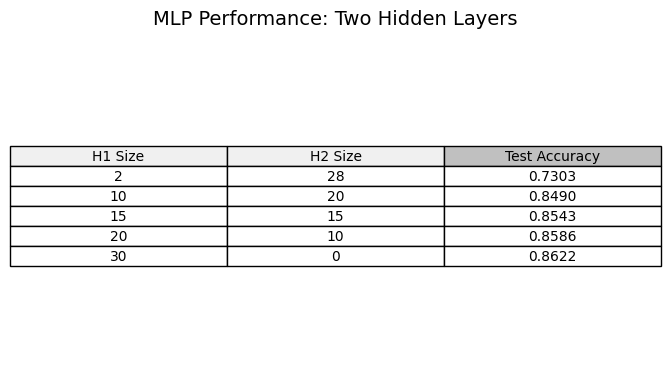

In [54]:
# Visualize results

# Code adapted from Gemini AI (Google 2025)
# Prompt: use matplotlib to create a table with columns...

import matplotlib.pyplot as plt

# --- REPLACE THIS WITH YOUR ACTUAL EXPERIMENTAL DATA ---
h1_sizes = [2,10,15,20,30]
h2_sizes = [28,20,15,10,0]
test_accs = [0.7303, 0.8490, 0.8543, 0.8586,0.8622] # Placeholder data
# --------------------------------------------------------

# Prepare data for the table: combine and format accuracy
table_data = []
for h1, h2, acc in zip(h1_sizes, h2_sizes, test_accs):
    # Format the accuracy to 4 decimal places for presentation
    table_data.append([h1, h2, f'{acc:.4f}']) 

column_headers = ["H1 Size", "H2 Size", "Test Accuracy"]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(7, 4))
ax.axis('off') # Hide the axes to only show the table

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_headers,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0', '#f0f0f0', '#c0c0c0']
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

ax.set_title("MLP Performance: Two Hidden Layers", fontsize=14, pad=20)
plt.show()

As seen, the sufficiency of architecture remains a significant drawback for deep networks. Specifically, a hidden layer size that is too small can reduce the granularity of inputs and reduce important signals. Thus, for our small experiment, all the deeper networks performed worse, likely because the size of 30 is already at or below the sufficient architecture and any smaller hidden layer size hurt the model performance.

In general, deeper architectures can learn greater representation, but this sufficiency of architecture should be kept in mind.

### Other Architectures and Increasing Neurons
We can also combine MLP architectures in unique ways. For examples, an architecture may feed the initial input into different MLP modules that combine at the end. This remaining section will increase the previous neuron count constraint and explore more creative architectures.

However, we first start with the baseline "naive" single hidden layer model again.

In [79]:
accuracies = []

In [80]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [81]:
model_1 = MLP_wide(500)
model_1.apply(init_weights)
train(model_1)

Epoch 0 loss: 1039.5824021548033
Epoch 1 loss: 789.9871809855103
Epoch 2 loss: 724.0993895083666
Epoch 3 loss: 682.9787411019206
Epoch 4 loss: 650.6433945223689
Epoch 5 loss: 622.490025550127
Epoch 6 loss: 601.9340923279524
Epoch 7 loss: 581.8926257267594
Epoch 8 loss: 563.5864734724164
Epoch 9 loss: 547.9853948913515
Epoch 10 loss: 533.3497261889279
Epoch 11 loss: 518.4317865036428
Epoch 12 loss: 506.1456335373223
Epoch 13 loss: 493.43149483576417
Epoch 14 loss: 480.7339237201959


In [82]:
_, testacc = evaluate(model_1)
accuracies.append(testacc)

Final test accuracy: 0.8814
Final train accuracy: 0.9129


The next two architectures are deep MLPs. Both have a depth of 4. This means that the model is composed of the inputs, 3 hidden layers, and the final output layer. One will have an inverted pyramid shape, where the initial 784 size input is fed into a small hidden layer and the subsequent hidden layers are larger. The other will have a pyramid shape, where the initial 784 size input is fed into slightly smaller and smaller hidden layers.

In [83]:
# Define inverted pyramid MLP
class MLP_inv(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50,200),
            nn.ReLU(),
            nn.Linear(200,500),
            nn.ReLU(),
            nn.Linear(500,10))

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.model(x)

In [84]:
model_2 = MLP_inv()
model_2.apply(init_weights)
train(model_2)

Epoch 0 loss: 1230.0447241738439
Epoch 1 loss: 836.080606251955
Epoch 2 loss: 756.8881580531597
Epoch 3 loss: 707.7953125312924
Epoch 4 loss: 670.8397687450051
Epoch 5 loss: 642.312321767211
Epoch 6 loss: 619.6746336333454
Epoch 7 loss: 599.8294603973627
Epoch 8 loss: 580.5074831955135
Epoch 9 loss: 564.6781395226717
Epoch 10 loss: 549.1631728000939
Epoch 11 loss: 538.4817274548113
Epoch 12 loss: 525.9016638435423
Epoch 13 loss: 513.546324621886
Epoch 14 loss: 503.6222798265517


In [85]:
_, testacc = evaluate(model_2)
accuracies.append(testacc)

Final test accuracy: 0.8720
Final train accuracy: 0.9018


In [86]:
# Define pyramid MLP
class MLP_pyramid(nn.Module):
    def __init__(self, act_fn = nn.ReLU):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 500),
            act_fn(),
            nn.Linear(500,200),
            act_fn(),
            nn.Linear(200,50),
            act_fn(),
            nn.Linear(50,10))

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.model(x)

In [87]:
model_3 = MLP_pyramid()
model_3.apply(init_weights)
train(model_3)

Epoch 0 loss: 1037.534193366766
Epoch 1 loss: 748.1796432435513
Epoch 2 loss: 674.8941819444299
Epoch 3 loss: 625.4562826342881
Epoch 4 loss: 591.0001682769507
Epoch 5 loss: 562.9379200935364
Epoch 6 loss: 536.066373500973
Epoch 7 loss: 510.68751557543874
Epoch 8 loss: 487.67783181741834
Epoch 9 loss: 469.2312937527895
Epoch 10 loss: 452.6054224167019
Epoch 11 loss: 432.918233750388
Epoch 12 loss: 416.0996570754796
Epoch 13 loss: 398.78215405344963
Epoch 14 loss: 384.4748426862061


In [88]:
_, testacc = evaluate(model_3)
accuracies.append(testacc)

Final test accuracy: 0.8891
Final train accuracy: 0.9347


The last two are examples of multiple MLP modules that combine at the end. The first structure combines two MLPs into a single one at the end through concatenation and a final linear layer. The second structure combines three MLPs into a single one at the end through concatenation and a final linear layer.

In [89]:
class MLP_combine_1(nn.Module):
    def __init__(self, act_fn = nn.ReLU):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Linear(28*28, 200),
            act_fn(),
            nn.Linear(200,100),
            act_fn(),
            nn.Linear(100,10),
            act_fn())
        self.model2 = nn.Sequential(
            nn.Linear(28*28, 200),
            act_fn(),
            nn.Linear(200,100),
            act_fn(),
            nn.Linear(100,10),
            act_fn())
        self.final_linear = nn.Linear(20,10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x1 = self.model1(x)
        x2 = self.model2(x)
        x_combine = torch.cat((x1,x2), dim=1)
        return self.final_linear(x_combine)

In [90]:
model_4 = MLP_combine_1()
model_4.apply(init_weights)
train(model_4)

Epoch 0 loss: 1110.743082076311
Epoch 1 loss: 785.5740125179291
Epoch 2 loss: 713.9027072489262
Epoch 3 loss: 662.3783757910132
Epoch 4 loss: 628.4541687183082
Epoch 5 loss: 594.5270000807941
Epoch 6 loss: 571.3219745270908
Epoch 7 loss: 548.1831331253052
Epoch 8 loss: 524.6128178797662
Epoch 9 loss: 507.9439117535949
Epoch 10 loss: 490.03333849832416
Epoch 11 loss: 471.83817107230425
Epoch 12 loss: 454.06931959837675
Epoch 13 loss: 439.6749617010355
Epoch 14 loss: 424.77687685005367


In [91]:
_, testacc = evaluate(model_4)
accuracies.append(testacc)

Final test accuracy: 0.8800
Final train accuracy: 0.9242


In [92]:
class MLP_combine_2(nn.Module):
    def __init__(self, act_fn = nn.ReLU):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Linear(28*28, 200),
            act_fn(),
            nn.Linear(200,100),
            act_fn(),
            nn.Linear(100,10),
            act_fn())
        self.model2 = nn.Sequential(
            nn.Linear(28*28, 200),
            act_fn(),
            nn.Linear(200,100),
            act_fn(),
            nn.Linear(100,10),
            act_fn())
        self.model3 = nn.Sequential(
            nn.Linear(28*28, 200),
            act_fn(),
            nn.Linear(200,100),
            act_fn(),
            nn.Linear(100,10),
            act_fn())
        self.final_linear = nn.Linear(30,10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x1 = self.model1(x)
        x2 = self.model2(x)
        x3 = self.model2(x)
        x_combine = torch.cat((x1,x2,x3), dim=1)
        return self.final_linear(x_combine)

In [93]:
model_5 = MLP_combine_2()
model_5.apply(init_weights)
train(model_5)

Epoch 0 loss: 1128.71875051409
Epoch 1 loss: 787.5590198040009
Epoch 2 loss: 708.8175064995885
Epoch 3 loss: 658.0496474877
Epoch 4 loss: 621.7937207147479
Epoch 5 loss: 588.0104911699891
Epoch 6 loss: 561.7345080636442
Epoch 7 loss: 540.9210887122899
Epoch 8 loss: 517.8913796804845
Epoch 9 loss: 496.3122906535864
Epoch 10 loss: 479.65007430687547
Epoch 11 loss: 463.58077481389046
Epoch 12 loss: 446.64322316274047
Epoch 13 loss: 432.2146224807948
Epoch 14 loss: 416.4031946621835


In [94]:
_, testacc = evaluate(model_5)
accuracies.append(testacc)

Final test accuracy: 0.8773
Final train accuracy: 0.9216


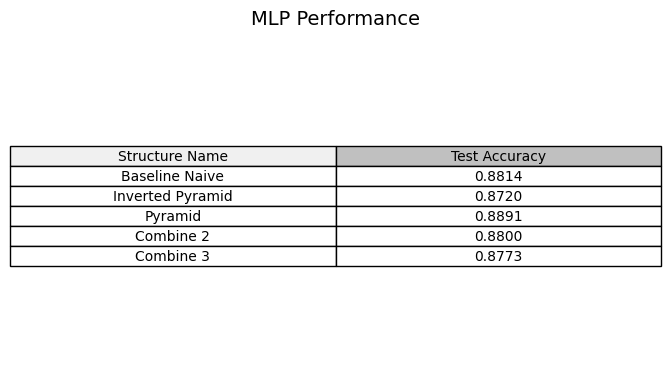

In [98]:
# Visualize results

# Code adapted from Gemini AI (Google 2025)
# Prompt: use matplotlib to create a table with columns...

import matplotlib.pyplot as plt

# --- REPLACE THIS WITH YOUR ACTUAL EXPERIMENTAL DATA ---
h1_sizes = ["Baseline Naive", "Inverted Pyramid", "Pyramid", "Combine 2", "Combine 3"]
test_accs = accuracies
# --------------------------------------------------------

# Prepare data for the table: combine and format accuracy
table_data = []
for h1, acc in zip(h1_sizes, test_accs):
    # Format the accuracy to 4 decimal places for presentation
    table_data.append([h1, f'{acc:.4f}']) 

column_headers = ["Structure Name", "Test Accuracy"]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(7, 4))
ax.axis('off') # Hide the axes to only show the table

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_headers,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0', '#c0c0c0']
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

ax.set_title("MLP Performance", fontsize=14, pad=20)
plt.show()

First comparing the pyramid to the inverted pyramid structure, the pyramid network performs better. This is expected, because the pyramid structure (going sequentially smaller hidden layer size) follows the sufficiency of architecture better. Additionally, the pyramid structure performs better than the baseline naive implementation. This was investigated in the toy experiments on how single hidden layer architectures are not the most neuron-efficient representations.

Next, the combination of 2 MLPs also performs fairly well, while the combination of 3 MLPs performs slightly worse. This is somewhat surprising, but it is possible that the dataset is more suited to the combination of two MLPs (visualized by linear combination of two complex shapes), rather than three.

### Activation Functions
For the top three models of the previous section, I also varied the activation functions. For the previous section, the ReLU activation function was used. This function is graded, so it passes a lot of information to subsequent layers. However, below zero, the ReLU function is just zero.

I will experiment with GeLU, a similar graded activation function that has smoother values around zero and non-zero values below zero, allowing for non-zero gradients when the input is zero.

In addition, I will experiment with Tanh. Unlike GeLU and ReLU, Tanh is less graded and only has values from -1 to 1, not ~0 to infinity. This means Tanh passes less information 

In [101]:
activation_functions = [nn.GELU, nn.Tanh]
accuracies_activations_1 = {}
accuracies_activations_2 = {}
accuracies_activations_3 = {}

In [102]:
for fn in activation_functions:
    model = MLP_wide(500, act_fn=fn)
    model.apply(init_weights)
    train(model)
    _, testacc = evaluate(model)
    accuracies_activations_1[fn] = testacc

Epoch 0 loss: 1034.7794522866607
Epoch 1 loss: 798.6927802935243
Epoch 2 loss: 735.0417297109962
Epoch 3 loss: 694.8860557153821
Epoch 4 loss: 663.5070324540138
Epoch 5 loss: 638.9667836353183
Epoch 6 loss: 616.9643556624651
Epoch 7 loss: 597.5203341320157
Epoch 8 loss: 581.6167180612683
Epoch 9 loss: 567.4191791377962
Epoch 10 loss: 552.1388240493834
Epoch 11 loss: 537.2784111332148
Epoch 12 loss: 525.6744785122573
Epoch 13 loss: 514.5842367038131
Epoch 14 loss: 503.20852517336607
Final test accuracy: 0.8787
Final train accuracy: 0.9101
Epoch 0 loss: 1052.8687429577112
Epoch 1 loss: 809.9881327450275
Epoch 2 loss: 748.2956850975752
Epoch 3 loss: 709.7200487032533
Epoch 4 loss: 680.9240124672651
Epoch 5 loss: 656.9757504500449
Epoch 6 loss: 636.5298777297139
Epoch 7 loss: 616.8192011080682
Epoch 8 loss: 601.6688949093223
Epoch 9 loss: 586.4563634395599
Epoch 10 loss: 573.4460413381457
Epoch 11 loss: 559.5655825920403
Epoch 12 loss: 547.5491297654808
Epoch 13 loss: 537.9088266119361
Epo

In [103]:
for fn in activation_functions:
    model = MLP_pyramid(act_fn=fn)
    model.apply(init_weights)
    train(model)
    _, testacc = evaluate(model)
    accuracies_activations_2[fn] = testacc

Epoch 0 loss: 1031.9636719375849
Epoch 1 loss: 748.2609307616949
Epoch 2 loss: 676.4413081854582
Epoch 3 loss: 629.4009748995304
Epoch 4 loss: 593.9402081221342
Epoch 5 loss: 564.4152362383902
Epoch 6 loss: 540.2156671136618
Epoch 7 loss: 520.5480066537857
Epoch 8 loss: 498.9674990102649
Epoch 9 loss: 483.0199639312923
Epoch 10 loss: 465.4239812232554
Epoch 11 loss: 449.875308226794
Epoch 12 loss: 435.2251767665148
Epoch 13 loss: 419.5474985949695
Epoch 14 loss: 406.05165990814567
Final test accuracy: 0.8837
Final train accuracy: 0.9273
Epoch 0 loss: 1056.622688934207
Epoch 1 loss: 769.0715625360608
Epoch 2 loss: 699.326472364366
Epoch 3 loss: 653.1640351638198
Epoch 4 loss: 620.2276017032564
Epoch 5 loss: 592.9037780016661
Epoch 6 loss: 567.8528915457428
Epoch 7 loss: 548.5423073321581
Epoch 8 loss: 530.6560782641172
Epoch 9 loss: 511.1485532410443
Epoch 10 loss: 495.93803530186415
Epoch 11 loss: 482.52149902656674
Epoch 12 loss: 466.7522369287908
Epoch 13 loss: 455.07153230160475
Epo

In [106]:
for fn in activation_functions:
    model = MLP_combine_1(act_fn=fn)
    model.apply(init_weights)
    train(model)
    _, testacc = evaluate(model)
    accuracies_activations_3[fn] = testacc

Epoch 0 loss: 1106.6067856699228
Epoch 1 loss: 778.7539843842387
Epoch 2 loss: 707.6658707857132
Epoch 3 loss: 662.3169385716319
Epoch 4 loss: 629.8525824770331
Epoch 5 loss: 600.0907275322825
Epoch 6 loss: 574.1335770897567
Epoch 7 loss: 554.1393624581397
Epoch 8 loss: 536.9097502045333
Epoch 9 loss: 516.4177578985691
Epoch 10 loss: 501.17824730463326
Epoch 11 loss: 485.9314363896847
Epoch 12 loss: 470.52205235511065
Epoch 13 loss: 457.21209182962775
Epoch 14 loss: 443.33790337853134
Final test accuracy: 0.8706
Final train accuracy: 0.9056
Epoch 0 loss: 1263.930911153555
Epoch 1 loss: 840.9514689072967
Epoch 2 loss: 745.0011765211821
Epoch 3 loss: 691.1716500744224
Epoch 4 loss: 650.969134286046
Epoch 5 loss: 621.5076471567154
Epoch 6 loss: 596.3632513694465
Epoch 7 loss: 574.4569713361561
Epoch 8 loss: 553.4711812697351
Epoch 9 loss: 538.2193519584835
Epoch 10 loss: 521.82039745152
Epoch 11 loss: 506.2336088307202
Epoch 12 loss: 492.43215066194534
Epoch 13 loss: 478.8132895156741
Epo

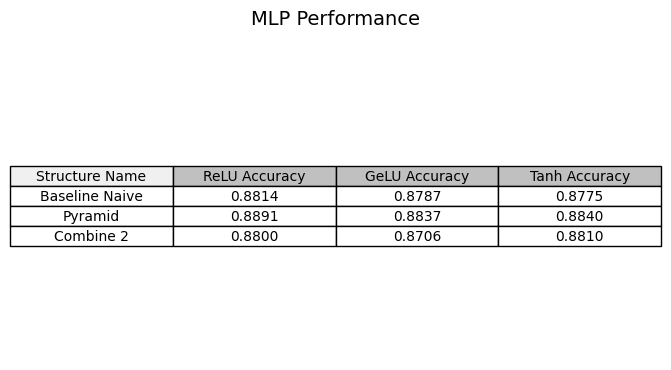

In [107]:
# Visualize results

# Code adapted from Gemini AI (Google 2025)
# Prompt: use matplotlib to create a table with columns...

import matplotlib.pyplot as plt

# --- REPLACE THIS WITH YOUR ACTUAL EXPERIMENTAL DATA ---
names = ["Baseline Naive", "Pyramid", "Combine 2"]
relu_accs = [accuracies[0]] + accuracies[2:4]
gelu_accs = [accuracies_activations_1[nn.GELU]]+[accuracies_activations_2[nn.GELU]]+[accuracies_activations_3[nn.GELU]]
tanh_accs = [accuracies_activations_1[nn.Tanh]]+[accuracies_activations_2[nn.Tanh]]+[accuracies_activations_3[nn.Tanh]]
# --------------------------------------------------------

# Prepare data for the table: combine and format accuracy
table_data = []
for name, racc, gacc, tacc in zip(names, relu_accs, gelu_accs,tanh_accs):
    # Format the accuracy to 4 decimal places for presentation
    table_data.append([name, f'{racc:.4f}', f'{gacc:.4f}', f'{tacc:.4f}']) 

column_headers = ["Structure Name", "ReLU Accuracy", "GeLU Accuracy", "Tanh Accuracy"]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(7, 4))
ax.axis('off') # Hide the axes to only show the table

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_headers,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0', '#c0c0c0','#c0c0c0', '#c0c0c0']
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

ax.set_title("MLP Performance", fontsize=14, pad=20)
plt.show()

For all the structures, going from ReLU to GeLU seems to have a minor decrease in performance. This is an interesting observation and may suggest that the smoothness of GeLU is not appropriate or that training takes longer with the more complex GeLU function.

For Tanh, the performance decreases with the baseline naive and pyramid structure, but increases for the combine MLP structure. Once again, the change is minor.

This is a suprising observation, because strongly graded activation functions like GeLU and ReLU are expected to work well with deeper networks like the pyramid and combine 2 structures. By comparison, Tanh should work better for wider structures like the baseline naive structure. However, instead the Tanh causes decrease in performance in the wide structure and instead only increases performance for the deep combine 2 structure.

On a high level, we do see how activation functions do have some impact on the model performance. ReLU works the best for all structure except the combine MLP which Tanh is better.

### Summary of Insights
1. A naive MLP with a single hidden layer can represent complex relationships with enough neurons.
2. Under neuron count constraints, deeper networks can approximate more complex functions.
3. Deeper networks under neuron contraints should be careful of the sufficiency of architecture with hidden layer sizes that are too small.
4. Activation function choice has a minor impact on model performance.
5. ReLU works the best for all structure except the combine MLP which Tanh is better.

## CNN
### Baseline Implementation
A baseline CNN is created with the following.

1. A single convolutional layer with 3 x 3 sized window for computing the convolution, with 32 filters
2. Maxpooling layer with 2 x 2 window size.
3. Flatten resulting features to reshape your output appropriately.
4. Dense layer on top of this (100 neurons) with ReLU activation
5. Dense layer with 10 neurons for calculating softmax output (Our classification result will output one of the ten possible classes, corresponding to our digits)

In [113]:
class baseline_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(13*13,100),
            nn.ReLU(),
            nn.Linear(100,10))
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [157]:
# Train and plot accuracies every 10 epochs

# Code adapted from Gemini AI (Google 2025)

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def evaluate(model):
    model.eval()
    total_correct_test = 0
    total_samples_test = 0
    total_correct_train = 0
    total_samples_train = 0
    with torch.no_grad():
        
        ## --- Test Set Accuracy ---
        for X_batch, y_batch in testloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, axis=1)
            
            # Count correct predictions and total samples in this batch
            correct_count = (predicted == y_batch).sum().item()
            batch_size = y_batch.shape[0]
            
            # Aggregate totals
            total_correct_test += correct_count
            total_samples_test += batch_size
    
        ## --- Training Set Accuracy ---
        for X_batch, y_batch in trainloader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, axis=1)
            
            # Count correct predictions and total samples in this batch
            correct_count = (predicted == y_batch).sum().item()
            batch_size = y_batch.shape[0]
            
            # Aggregate totals
            total_correct_train += correct_count
            total_samples_train += batch_size
    
    # Final calculation: total correct / total samples
    final_test_accuracy = total_correct_test / total_samples_test
    final_train_accuracy = total_correct_train / total_samples_train

    return final_train_accuracy, final_test_accuracy

def train_CNN(model, num_epochs=50, plot_interval=10, lr=0.01):
    """
    Trains a CNN model, evaluates accuracy periodically, and plots the learning curves.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    epoch_points = []
    train_acc_points = []
    test_acc_points = []
    
    # ----------------- Initial Evaluation (Epoch 0) -----------------
    # Evaluate and store initial (random) performance
    model.eval()
    train_acc, test_acc = evaluate(model)
    
    epoch_points.append(0)
    train_acc_points.append(train_acc)
    test_acc_points.append(test_acc)
    
    if plot_interval > 0:
        print(f"Epoch 0 (Initial): Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    # ----------------- TRAINING LOOP -----------------
    for epoch in range(1, num_epochs + 1):
        
        model.train() # Set model to training mode
        
        for X_batch, y_batch in trainloader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # ----------------- EVALUATION & STORAGE -----------------
        # Evaluate if plot_interval condition is met OR if it's the last epoch
        if (plot_interval != 0 and epoch % plot_interval == 0) or epoch == num_epochs:
            model.eval() # Set model to evaluation mode for consistent accuracy
            train_acc, test_acc = evaluate(model)
            
            # Store results
            epoch_points.append(epoch)
            train_acc_points.append(train_acc)
            test_acc_points.append(test_acc)
            
            # Print only if plot_interval is positive
            if plot_interval > 0:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
            
    # ----------------- FINAL PLOT -----------------
    if plot_interval > 0:
        plot_learning_curves(epoch_points, train_acc_points, test_acc_points)
    
    # Print the final result regardless of plot_interval setting
    print(f"\nTraining Complete. Final Train Acc: {train_acc:.4f}, Final Test Acc: {test_acc:.4f}")

    return train_acc, test_acc

def plot_learning_curves(epoch_points, train_acc_points, test_acc_points):
    """Helper function to create the accuracy plot."""
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_points, train_acc_points, label='Training Accuracy', marker='o')
    plt.plot(epoch_points, test_acc_points, label='Test Accuracy', marker='x')

    plt.title('Learning Curves: Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [118]:
base_CNN = baseline_CNN()

Epoch 0 (Initial): Train Acc = 0.0788, Test Acc = 0.0729
Epoch 10: Train Acc = 0.8813, Test Acc = 0.8588
Epoch 20: Train Acc = 0.8976, Test Acc = 0.8692
Epoch 30: Train Acc = 0.9073, Test Acc = 0.8726
Epoch 40: Train Acc = 0.9162, Test Acc = 0.8707
Epoch 50: Train Acc = 0.9304, Test Acc = 0.8715


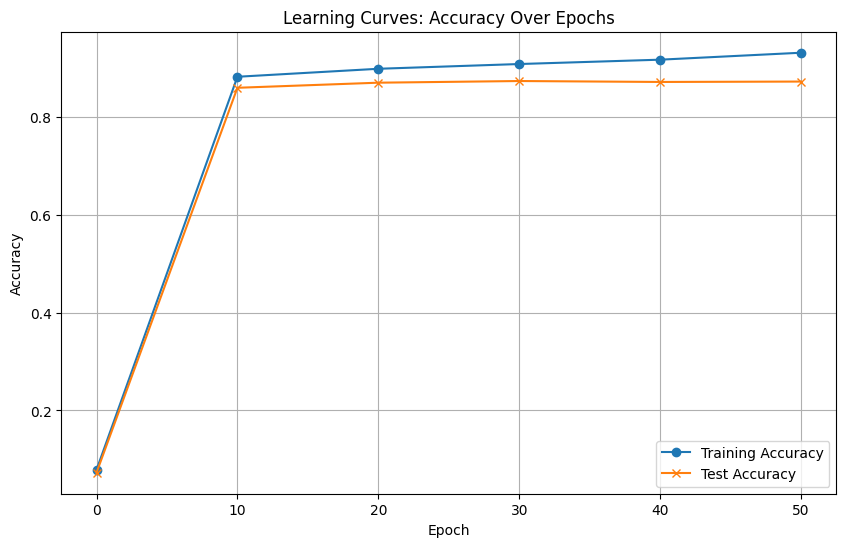

(0.9303833333333333, 0.8715)

In [119]:
train_CNN(base_CNN)

### Dropout
To avoid over-fitting, a dropout layer can be added. This causes the input to that layer to be randomly set to zero. This effectively turns off neurons of the previous layer during training.

In [120]:
class dropout_CNN(nn.Module):
    def __init__(self, act_fn = nn.ReLU):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(13*13,100),
            nn.ReLU(),
            nn.Linear(100,10))
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.1497, Test Acc = 0.1502
Epoch 10: Train Acc = 0.8574, Test Acc = 0.8426
Epoch 20: Train Acc = 0.8662, Test Acc = 0.8565
Epoch 30: Train Acc = 0.8529, Test Acc = 0.8419
Epoch 40: Train Acc = 0.8638, Test Acc = 0.8490
Epoch 50: Train Acc = 0.8021, Test Acc = 0.7848


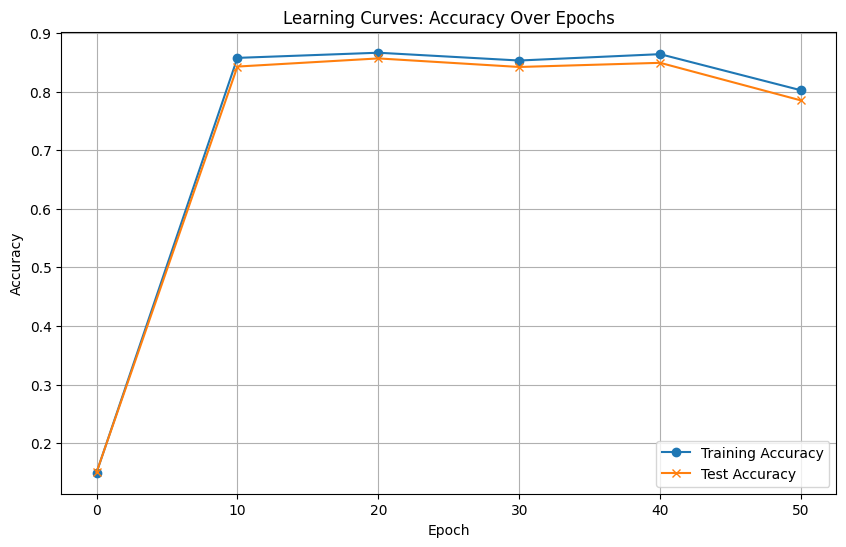

(0.8021166666666667, 0.7848)

In [121]:
dropout_CNN = dropout_CNN()
train_CNN(dropout_CNN)

Interestingly, the addition of dropout makes the overall test model performance slightly worse. Without dropout, the model has a 87.26% accuracy. With dropout, the model has a 85.65% test accuracy. However, the usefulness of dropout is still seen. The difference between the training and test accuracies is much smaller when dropout is applied. This shows how dropout is a useful tool to reduce overfitting. In different datasets and architectures where overfitting is a larger issue, dropout can be a good strategy for success. However, here, the negative effects of dropout seems to overpower the benefits from reducing overfitting. The negative effects involve decreased performance of both the training and test accuracies and can be explained by how extreme dropout probabilties can slow down training as many neurons are inactive and do not get updated during each training epoch.

### More Convolutions
I will also try adding another convolutional layer and maxpooling layer. This emulates distributed scanning since we are taking the convolution of a convolution output.

In [126]:
class distributed_CNN(nn.Module):
    def __init__(self, act_fn = nn.ReLU):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(4*4,100),
            nn.ReLU(),
            nn.Linear(100,10))
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

Epoch 0 (Initial): Train Acc = 0.1337, Test Acc = 0.1366
Epoch 10: Train Acc = 0.5477, Test Acc = 0.5383


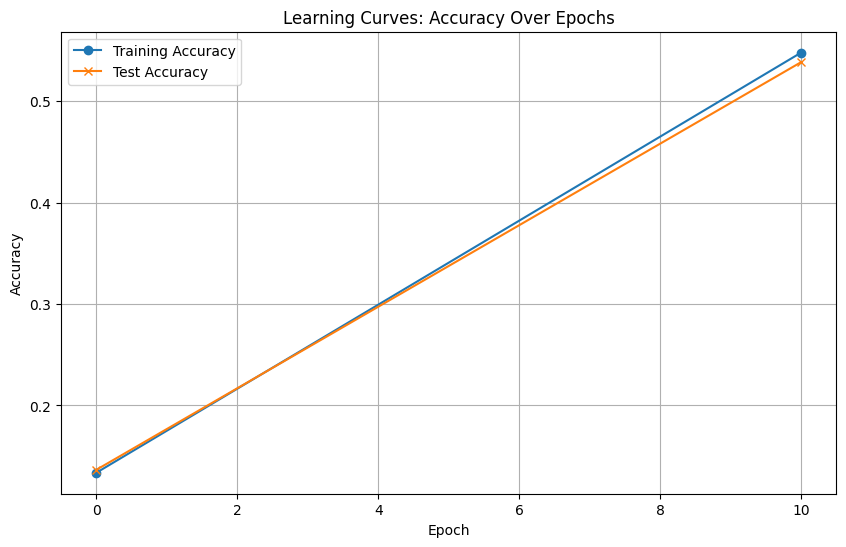

Final test accuracy: 0.5383


In [127]:
dist_CNN = distributed_CNN()
_, test_acc = train_CNN(dist_CNN, num_epochs=10)
print(f"Final test accuracy: {test_acc}")

Without changing anything else, adding another convolution layer significantly decreased the performance of the model. Typically, we expect distributed scanning to be a powerful tool, such that the initial convolution does not have to be precise and larger patterns can be learned in later layers. However, I hypothesize that the addition of a layer failed here, because the convolutions were too large. With both max pooling and the large convolutions without padding, these techniques downscaled the data too much and caused important signals to be lost during downsampling. This is a similar issue to the sufficiency of architecture investigated with MLPs.

### Learning Rate

In [155]:
class lr_CNN(nn.Module):
    def __init__(self, act_fn = nn.ReLU):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(6*6,100),
            nn.ReLU(),
            nn.Linear(100,10))
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [158]:
CNN = lr_CNN()
_, test_acc = train_CNN(CNN, num_epochs=10, lr=0.001, plot_interval=0)
print(f"Final test accuracy: {test_acc}")


Training Complete. Final Train Acc: 0.7525, Final Test Acc: 0.7434
Final test accuracy: 0.7434


In [159]:
CNN = lr_CNN()
_, test_acc = train_CNN(CNN, num_epochs=10, lr=0.01, plot_interval=0)
print(f"Final test accuracy: {test_acc}")


Training Complete. Final Train Acc: 0.7238, Final Test Acc: 0.7101
Final test accuracy: 0.7101


In [160]:
CNN = lr_CNN()
_, test_acc = train_CNN(CNN, num_epochs=10, lr=0.1, plot_interval=0)
print(f"Final test accuracy: {test_acc}")


Training Complete. Final Train Acc: 0.1000, Final Test Acc: 0.1000
Final test accuracy: 0.1


The second training used the 0.01 learning rate used throughout the notebook. This is the baseline.

When learning rate is lowered to 0.001, the final test accuracy is slightly better. This indicates that 0.001 is still high enough for the gradient descent steps to have reasonable changes per epoch. It is higher than 0.01, meaning that the baseline training learning rate had some bad convergence due to too large steps (jittering or divergence).

When the learning rate is increased to 0.1, this jittering or divergence effect is completely dominant. The model fails to converge usefully in the 10 epochs. The final test accuracy is 0.1 which is as bad as a random classifier for the 10 classes. Essentially, the model parameters are jumping around too much with each epoch and failing to go smoothly towards the minimum.

# Written Exercises
## Part a
An MLP with a hidden layer of ReLU units can represent the same functions as an MLP with linear units. However, the ReLU MLP would need more number of hidden nodes, possibly up to double.

If we just consider the positive output values of the hidden layer, the ReLU activation function will not change the value of the unit. Thus for the positive values, the ReLU units can represent the same functions as the MLP with linear units. However, if the unit outputs are negative, the ReLU activation will turn these to zero. Fortunately, an MLP with hidden layers of ReLU units can still represent these negative values by having positive outputs of the ReLU unit multiplied by a negative parameter in the following linear layer. This would require another ReLU unit to represent one linear unit.

## Part b
An MLP with one hidden layer of linear units cannot represent the same mapping of an MLP with ReLU units.

If there is no activation function between two linear layers of an MLP, then this is mathematically equivalent to a single linear layer. We can show this by saying that.

H = W1(X)
O = W2(H)

O = W2(W1(X)) = W(X)

A single linear layer does not have the representative power of an MLP with ReLU units. A single linear layer might represent a linear function that looks like a hyperplane in the high dimensional geometry. By comparison, even the very simple ReLU activation of the y=x function has the kink at x=0 and different slopes between the positive and negative inputs that a single hyperplane cannot represent.

We can additionally construct a simple counterexample with boolean operations. An MLP of two ReLU units on a 1 dimensional input can represent "XOR" if each ReLU unit faces opposite directions and the final linear combination acts as an "OR". However, the linear units cannot be linearly added the same way. The negative of one linear unit will cancel out the positive of the opposite-facing linear unit.